<a href="https://colab.research.google.com/github/Chanaka3534/FYP_LSTM/blob/1.0/FYP(LSTM)1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1435 - val_loss: 0.0295
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0279 - val_loss: 0.0223
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0222 - val_loss: 0.0288
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0191 - val_loss: 0.0179
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0150 - val_loss: 0.0105
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0117 - val_loss: 0.0087
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113 - val_loss: 0.0069
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - val_loss: 0.0059
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0075 - val_loss: 0.0062
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - val_loss: 0.0051
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - val_loss: 0.0101
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

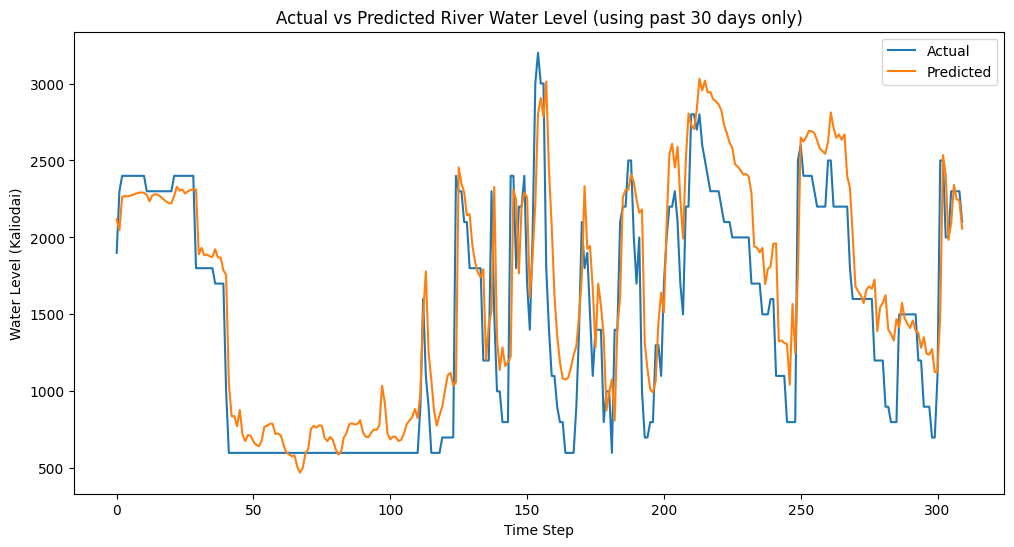

Mean Squared Error (MSE): 130079.73
Root Mean Squared Error (RMSE): 360.67
Mean Absolute Error (MAE): 272.28
R² Score: 0.7562
MAE % of mean: 18.42%
RMSE % of mean: 24.40%


In [1]:
# 📦 1) Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 🗂️ 2) Load dataset
df = pd.read_csv('FYP_DATA.csv')

# ➡️ 3) Convert columns
df['Resovior water level(m)'] = pd.to_numeric(df['Resovior water level(m)'], errors='coerce')
df['Resovior discharge rate'] = pd.to_numeric(df['Resovior discharge rate'], errors='coerce')
df['Water level(Kaliodai)'] = pd.to_numeric(df['Water level(Kaliodai)'], errors='coerce')

df = df.dropna()

# ✅ 4) Use only required columns: NO Prev_Water_Level
features = df[['Catchment Rainfall',
               'Downstream rainfall',
               'Resovior water level(m)',
               'Resovior discharge rate',
               'Water level(Kaliodai)']]

target = df['Water level(Kaliodai)'].values.reshape(-1, 1)  # Still predicting same

# 🔄 5) Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target)

# 📏 6) Create sequences
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])    # past 30 days
        ys.append(y[i+time_steps])      # today's level (next day)
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

# 📊 7) Train-test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# 🧠 8) LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, X_seq.shape[2])),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()

# 🚀 9) Train
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.1,
                    verbose=1)

# ✅ 10) Predict & inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# 📈 11) Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted River Water Level (using past 30 days only)')
plt.xlabel('Time Step')
plt.ylabel('Water Level (Kaliodai)')
plt.legend()
plt.show()

# 🏅 12) Evaluate
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

mean_y = np.mean(y_test_actual)
mae_percent = (mae / mean_y) * 100
rmse_percent = (rmse / mean_y) * 100

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAE % of mean: {mae_percent:.2f}%")
print(f"RMSE % of mean: {rmse_percent:.2f}%")
